In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


# Preparing Data

In [42]:
metadata_df = pd.read_csv('/Users/joanna/datasci_281/final_project/HAM10000_metadata.csv')
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [43]:
metadata_df = metadata_df.drop_duplicates(subset = 'lesion_id')

In [44]:
features_df = metadata_df[['image_id', 'dx', 'age']]
localization_df = pd.get_dummies(metadata_df['localization'], dtype = float).drop(columns = ['unknown'])
features_df = pd.concat([features_df, localization_df], axis = 1)

sex_df = pd.get_dummies(metadata_df['sex'], dtype = float).drop(columns = ['unknown'])
features_df = pd.concat([features_df, sex_df], axis = 1)

mean_HSV = pd.read_csv('/Users/joanna/datasci_281/final_project/average_HSV.csv')
features_df = pd.merge(features_df, mean_HSV, how = 'left')

In [45]:
dataset_df = pd.read_csv('dataset/dataset.csv')
dataset_df = dataset_df.rename(columns = {"Unnamed: 0": 'image_id'})
dataset_df.head()

,image_id,lesion_skew_lbp,lesion_kurtosis_lbp,radial_mean_slope_lbp,radial_std_slope_lbp,max_mean_location_lbp,radial_std_gabor,lesion_skew_gabor,lesion_kurtosis_gabor,radial_mean_slope_gabor,...,value_histogram_246,value_histogram_247,value_histogram_248,value_histogram_249,value_histogram_250,value_histogram_251,value_histogram_252,value_histogram_253,value_histogram_254,value_histogram_255
0,ISIC_0024306,1.479220,1.698883,-0.271104,-0.867224,0.0,13.888199,-1.443745,0.942281,0.131855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,ISIC_0024307,0.732745,-0.440050,-1.170712,-2.089826,1.0,4.813448,0.666198,-0.503684,-0.370137,...,6.0,3.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0
2,ISIC_0024308,1.532073,1.899544,-0.681541,-1.387129,0.0,8.677227,0.276372,-1.837979,-0.200521,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,-0.395309,-1.355692,-1.072684,-1.904152,1.0,1.743708,-2.130681,4.785650,0.774746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,0.704363,0.214108,-2.252855,-2.330819,2.0,3.699619,-1.024185,0.610274,0.111822,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [46]:
hog_features = pd.read_csv('/Users/joanna/datasci_281/final_project/hog_features.csv')
features_df = pd.merge(features_df, hog_features)

In [47]:
#lbp_features
lbp_feature_cols = [col for col in dataset_df.columns if 'lbp' in col]
lbp_feature_cols.append('image_id')
lbp_features_df = dataset_df[lbp_feature_cols]
features_df = pd.merge(features_df, lbp_features_df)

In [48]:
# gabor features
gabor_feature_cols = [col for col in dataset_df.columns if 'gabor' in col]
gabor_feature_cols.append('image_id')
gabor_features_df = dataset_df[gabor_feature_cols]
features_df = pd.merge(features_df, gabor_features_df)

In [49]:
features_df = pd.merge(features_df, dataset_df[['image_id', 'Area', 'symmetry_score', 'Perimeter', 'Eccentricity']])

In [34]:
# glcm = pd.read_csv('/Users/joanna/datasci_281/final_project/glcm.csv')
# glcm_subset = glcm[['image_id', 'contrast', 'homogeneity', 'correlation']]
# features_df = pd.merge(features_df, glcm_subset)

In [35]:
# resnet_df = pd.read_csv('resnet50_pca.csv')
# features_df = pd.merge(features_df, resnet_df)

In [50]:
color_features = pd.read_csv('/Users/joanna/datasci_281/final_project/colorAlex.csv')
color_features_subset = color_features[['image_id','mean_hue_inside_mask', 'mean_hue_outside_mask']]
features_df = pd.merge(features_df, color_features_subset)

In [51]:
features_df = features_df.set_index('image_id')

In [52]:
features_df.head()

,dx,age,abdomen,acral,back,chest,ear,face,foot,genital,...,radial_std_slope_gabor,difference_from_skin_gabor,lesion_region_inter_quartile_range_gabor,max_std_location_gabor,Area,symmetry_score,Perimeter,Eccentricity,mean_hue_inside_mask,mean_hue_outside_mask
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0027419,bkl,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.413455,-0.141627,1.0,1.0,85333.0,0.707304,1251.785930,0.686623,131.477142,160.644327
ISIC_0026769,bkl,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.913690,-0.040084,1.0,0.0,72118.0,0.683762,1113.560533,0.646589,161.490370,160.227462
ISIC_0031633,bkl,75.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.723845,-0.122373,1.0,0.0,102934.0,0.749373,1274.011327,0.418797,140.833981,157.829337
ISIC_0029176,bkl,60.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.176197,-0.779368,0.0,0.0,48789.0,0.727126,847.737157,0.582010,118.697965,86.168622
ISIC_0025837,bkl,70.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.099295,0.012697,2.0,2.0,21000.0,0.716079,565.386868,0.483655,166.001476,167.256386


## Train Test Split

In [53]:
Y = features_df['dx']
X = features_df.drop('dx', axis = 1)

In [54]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state= 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size= 0.5, stratify = y_temp)

In [55]:
# any NaN will be the average of the column
def fillna_mean(df):
    for col in df.columns:
        if df[col].isnull().any():
            mean_value = df[col].mean()
            df[col] = df[col].fillna(mean_value)
    return df 

X_train = fillna_mean(X_train)
X_val = fillna_mean(X_val)
X_test = fillna_mean(X_test)

def scale_data(df):
    # scaling variables
    min_max_scaler = MinMaxScaler()
    df['age'] = min_max_scaler.fit_transform(df[['age']])
    df['Area'] = min_max_scaler.fit_transform(df[['Area']])
    df['Perimeter'] = min_max_scaler.fit_transform(df[['Perimeter']])
    #df['contrast'] = min_max_scaler.fit_transform(df[['contrast']])
    df['mean_hue_inside_mask'] = min_max_scaler.fit_transform(df[['mean_hue_inside_mask']])
    df['mean_hue_outside_mask'] = min_max_scaler.fit_transform(df[['mean_hue_outside_mask']])

    standard_scaler = StandardScaler()
    df['hue_average'] = standard_scaler.fit_transform(df[['hue_average']])
    df['saturation_average'] = standard_scaler.fit_transform(df[['saturation_average']])
    df['value_average'] = standard_scaler.fit_transform(df[['value_average']])

    lbp_feature_cols = [col for col in df.columns if 'lbp' in col]
    for col in lbp_feature_cols:
        df[col] = standard_scaler.fit_transform(df[[col]])

    gabor_feature_cols = [col for col in df.columns if 'gabor' in col]
    for col in gabor_feature_cols:
        df[col] = standard_scaler.fit_transform(df[[col]])

    return df

X_train = scale_data(X_train)
X_val = scale_data(X_val)
X_test = scale_data(X_test)

## Oversampling

In [56]:
sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Modeling

## Logistic Regression

In [18]:
logReg = LogisticRegression(random_state = 42, class_weight = 'balanced', solver = 'lbfgs')
param_grid = {
    'max_iter': [1000, 2000],
    'C': [0.1, 0.5, 1]
}
grid_search = GridSearchCV(logReg, param_grid, scoring = 'roc_auc_ovr')
grid_search.fit(X_train_res, y_train_res)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1, 'max_iter': 1000}
0.9480443650667192


Accuracy: 0.6696428571428571

Classification Report:
               precision    recall  f1-score   support

       akiec       0.31      0.65      0.42        34
         bcc       0.48      0.59      0.53        49
         bkl       0.46      0.44      0.45       109
          df       0.19      0.73      0.30        11
         mel       0.29      0.49      0.36        92
          nv       0.95      0.73      0.83       810
        vasc       0.11      0.53      0.19        15

    accuracy                           0.67      1120
   macro avg       0.40      0.59      0.44      1120
weighted avg       0.79      0.67      0.71      1120



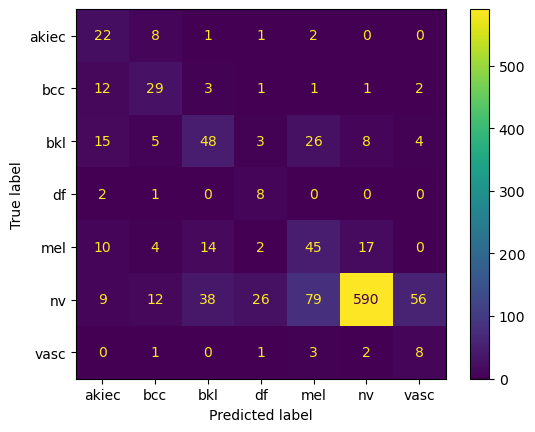

In [19]:
logReg = LogisticRegression(random_state = 42, class_weight = 'balanced', solver = 'lbfgs', max_iter = 1000, C = 1).fit(X_train_res,y_train_res)
y_pred = logReg.predict(X_val)

y_pred = logReg.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred), display_labels=logReg.classes_)
disp.plot()

Accuracy: 0.656556645851918

Classification Report:
               precision    recall  f1-score   support

       akiec       0.29      0.66      0.40        35
         bcc       0.40      0.43      0.41        49
         bkl       0.42      0.40      0.41       109
          df       0.16      0.55      0.24        11
         mel       0.29      0.55      0.38        92
          nv       0.97      0.72      0.83       811
        vasc       0.07      0.29      0.11        14

    accuracy                           0.66      1121
   macro avg       0.37      0.51      0.40      1121
weighted avg       0.79      0.66      0.70      1121



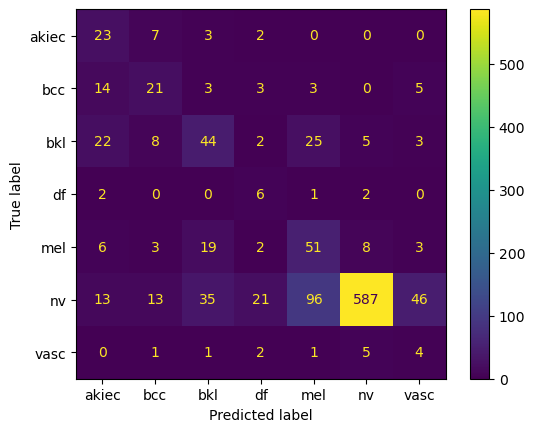

In [20]:
y_pred = logReg.predict(X_test)

y_pred = logReg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=logReg.classes_)
disp.plot()

In [21]:
y_pred = logReg.predict(X_train)

y_pred = logReg.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print("\nClassification Report:\n", classification_report(y_train, y_pred))

Accuracy: 0.6798623063683304

Classification Report:
               precision    recall  f1-score   support

       akiec       0.39      0.62      0.48       159
         bcc       0.45      0.60      0.52       229
         bkl       0.47      0.48      0.47       509
          df       0.20      0.92      0.32        51
         mel       0.34      0.55      0.42       430
          nv       0.97      0.72      0.83      3782
        vasc       0.14      0.78      0.23        69

    accuracy                           0.68      5229
   macro avg       0.42      0.67      0.47      5229
weighted avg       0.81      0.68      0.72      5229



## Random Forest

### Random Forest with Class Weighting

In [22]:
rf_cw = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,5,10,12]
}
grid_search = GridSearchCV(rf_cw, param_grid, scoring = 'roc_auc_ovr')
grid_search.fit(X_train_res, y_train_res)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 12, 'n_estimators': 300}
0.9974241524665682


Accuracy: 0.7901785714285714

Classification Report:
               precision    recall  f1-score   support

       akiec       0.43      0.59      0.50        34
         bcc       0.51      0.53      0.52        49
         bkl       0.52      0.53      0.53       109
          df       0.25      0.27      0.26        11
         mel       0.37      0.32      0.34        92
          nv       0.92      0.92      0.92       810
        vasc       0.25      0.13      0.17        15

    accuracy                           0.79      1120
   macro avg       0.46      0.47      0.46      1120
weighted avg       0.79      0.79      0.79      1120



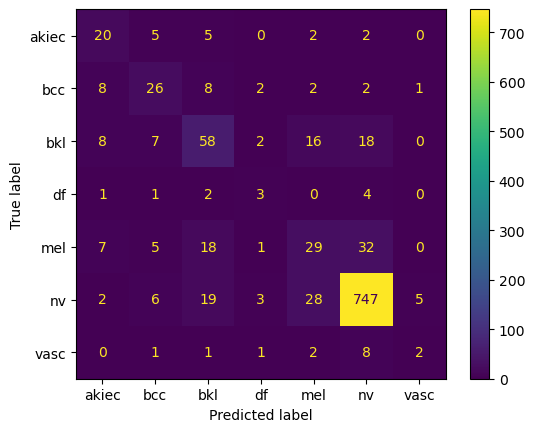

In [57]:
rf_cw = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=300, max_depth= 12)
rf_cw.fit(X_train_res, y_train_res)
y_pred = rf_cw.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred), display_labels=rf_cw.classes_)
disp.plot()

Accuracy: 0.7475468331846565

Classification Report:
               precision    recall  f1-score   support

       akiec       0.33      0.43      0.38        35
         bcc       0.44      0.59      0.50        49
         bkl       0.47      0.42      0.44       109
          df       0.25      0.36      0.30        11
         mel       0.29      0.30      0.30        92
          nv       0.90      0.88      0.89       811
        vasc       0.56      0.36      0.43        14

    accuracy                           0.75      1121
   macro avg       0.46      0.48      0.46      1121
weighted avg       0.76      0.75      0.75      1121



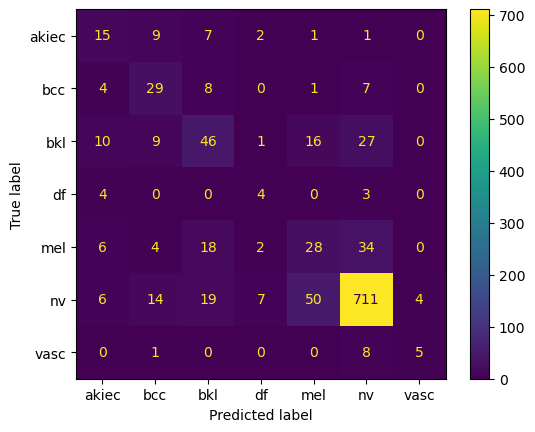

In [58]:
y_pred = rf_cw.predict(X_test)

y_pred = rf_cw.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=rf_cw.classes_)
disp.plot()

In [59]:
y_pred = rf_cw.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print("\nClassification Report:\n", classification_report(y_train, y_pred))

Accuracy: 0.9732262382864793

Classification Report:
               precision    recall  f1-score   support

       akiec       0.85      1.00      0.92       159
         bcc       0.92      0.99      0.95       229
         bkl       0.97      0.97      0.97       509
          df       0.93      1.00      0.96        51
         mel       0.87      0.95      0.91       430
          nv       1.00      0.97      0.99      3782
        vasc       0.95      1.00      0.97        69

    accuracy                           0.97      5229
   macro avg       0.92      0.98      0.95      5229
weighted avg       0.98      0.97      0.97      5229



### Random Forest with Bootstrap Class Weighting

In [60]:
rf_bcw = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,5,10,12]
}
grid_search = GridSearchCV(rf_bcw, param_grid, scoring = 'roc_auc_ovr')
grid_search.fit(X_train_res, y_train_res)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 12, 'n_estimators': 300}
0.997398139974286


Accuracy: 0.7821428571428571

Classification Report:
               precision    recall  f1-score   support

       akiec       0.41      0.56      0.47        34
         bcc       0.51      0.55      0.53        49
         bkl       0.51      0.50      0.50       109
          df       0.27      0.27      0.27        11
         mel       0.34      0.34      0.34        92
          nv       0.92      0.91      0.92       810
        vasc       0.27      0.20      0.23        15

    accuracy                           0.78      1120
   macro avg       0.46      0.48      0.47      1120
weighted avg       0.78      0.78      0.78      1120



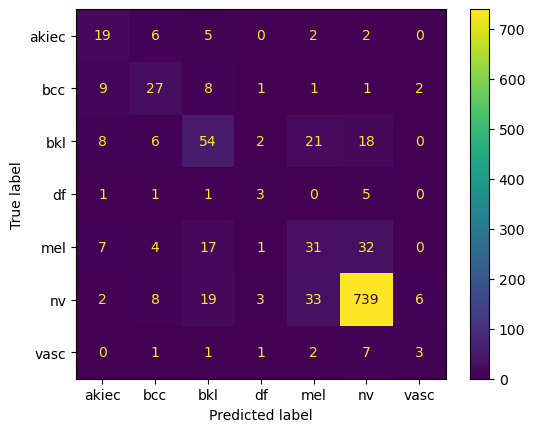

In [61]:
rf_bcw = RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_estimators= 300, max_depth= 12)
rf_bcw.fit(X_train_res, y_train_res)
y_pred = rf_bcw.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred), display_labels= rf_bcw.classes_)
disp.plot()

Accuracy: 0.7618198037466548

Classification Report:
               precision    recall  f1-score   support

       akiec       0.33      0.43      0.38        35
         bcc       0.43      0.59      0.50        49
         bkl       0.48      0.43      0.45       109
          df       0.28      0.45      0.34        11
         mel       0.35      0.33      0.34        92
          nv       0.90      0.89      0.90       811
        vasc       0.67      0.43      0.52        14

    accuracy                           0.76      1121
   macro avg       0.49      0.51      0.49      1121
weighted avg       0.77      0.76      0.76      1121



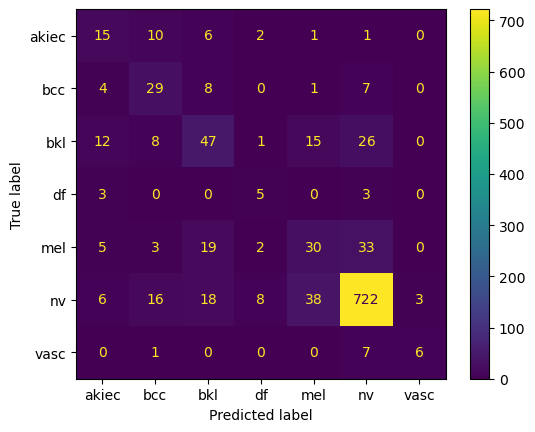

In [62]:
y_pred = rf_bcw.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels= rf_bcw.classes_)
disp.plot()

Accuracy: 0.9726525148211895

Classification Report:
               precision    recall  f1-score   support

       akiec       0.84      1.00      0.91       159
         bcc       0.93      0.99      0.96       229
         bkl       0.96      0.97      0.97       509
          df       0.91      1.00      0.95        51
         mel       0.87      0.95      0.91       430
          nv       1.00      0.97      0.99      3782
        vasc       0.93      1.00      0.97        69

    accuracy                           0.97      5229
   macro avg       0.92      0.98      0.95      5229
weighted avg       0.97      0.97      0.97      5229



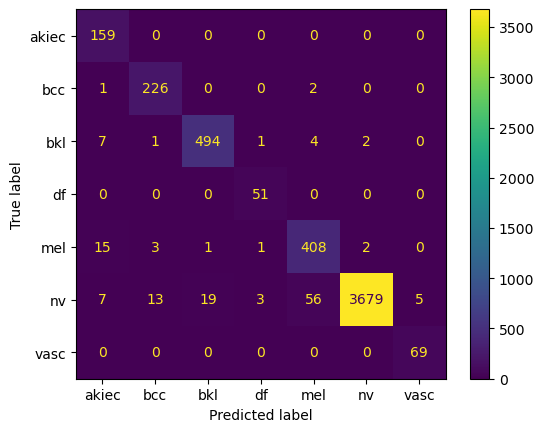

In [63]:
y_pred = rf_bcw.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print("\nClassification Report:\n", classification_report(y_train, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred), display_labels= rf_bcw.classes_)
disp.plot()

## Balanced Random Forest

In [64]:
brf = BalancedRandomForestClassifier(random_state=42, class_weight = 'balanced')
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,5,10,12]
}
grid_search = GridSearchCV(brf, param_grid, scoring = 'roc_auc_ovr')
grid_search.fit(X_train_res, y_train_res)

print(grid_search.best_params_)
print(grid_search.best_score_)

/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `Fals

{'max_depth': 12, 'n_estimators': 300}
0.9974931577849541


/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `Fals

Accuracy: 0.7875

Classification Report:
               precision    recall  f1-score   support

       akiec       0.44      0.62      0.51        34
         bcc       0.54      0.57      0.55        49
         bkl       0.55      0.50      0.53       109
          df       0.25      0.27      0.26        11
         mel       0.34      0.32      0.33        92
          nv       0.92      0.92      0.92       810
        vasc       0.20      0.13      0.16        15

    accuracy                           0.79      1120
   macro avg       0.46      0.48      0.47      1120
weighted avg       0.79      0.79      0.79      1120



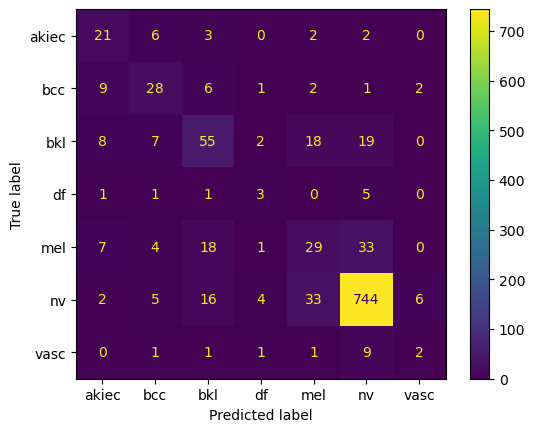

In [65]:
brf = BalancedRandomForestClassifier(n_estimators=300, max_depth = 12, random_state=42, class_weight = 'balanced')

brf.fit(X_train_res, y_train_res)
y_pred = brf.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred), display_labels=brf.classes_)
disp.plot()

Accuracy: 0.7511150758251561

Classification Report:
               precision    recall  f1-score   support

       akiec       0.30      0.40      0.35        35
         bcc       0.40      0.55      0.46        49
         bkl       0.45      0.41      0.43       109
          df       0.29      0.45      0.36        11
         mel       0.33      0.32      0.32        92
          nv       0.90      0.88      0.89       811
        vasc       0.60      0.43      0.50        14

    accuracy                           0.75      1121
   macro avg       0.47      0.49      0.47      1121
weighted avg       0.76      0.75      0.76      1121



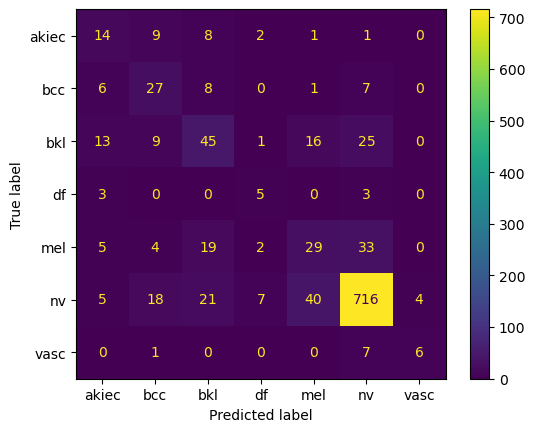

In [67]:
y_pred = brf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=brf.classes_)
disp.plot()

In [68]:
y_pred = brf.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print("\nClassification Report:\n", classification_report(y_train, y_pred))

Accuracy: 0.9728437559762861

Classification Report:
               precision    recall  f1-score   support

       akiec       0.85      1.00      0.92       159
         bcc       0.93      0.99      0.96       229
         bkl       0.96      0.97      0.97       509
          df       0.93      1.00      0.96        51
         mel       0.87      0.95      0.91       430
          nv       1.00      0.97      0.99      3782
        vasc       0.95      1.00      0.97        69

    accuracy                           0.97      5229
   macro avg       0.93      0.98      0.95      5229
weighted avg       0.97      0.97      0.97      5229



In [69]:
brf_bss = BalancedRandomForestClassifier(random_state=42, class_weight = 'balanced_subsample')
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3,5,10,12]
}
grid_search = GridSearchCV(brf_bss, param_grid, scoring = 'roc_auc_ovr')
grid_search.fit(X_train_res, y_train_res)

print(grid_search.best_params_)
print(grid_search.best_score_)

/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `Fals

{'max_depth': 12, 'n_estimators': 300}
0.9974776470212898


/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/joanna/anaconda3/envs/datasci_281/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `Fals

Accuracy: 0.7848214285714286

Classification Report:
               precision    recall  f1-score   support

       akiec       0.44      0.59      0.51        34
         bcc       0.54      0.53      0.54        49
         bkl       0.51      0.52      0.52       109
          df       0.33      0.27      0.30        11
         mel       0.32      0.30      0.31        92
          nv       0.92      0.92      0.92       810
        vasc       0.25      0.20      0.22        15

    accuracy                           0.78      1120
   macro avg       0.47      0.48      0.47      1120
weighted avg       0.78      0.78      0.78      1120



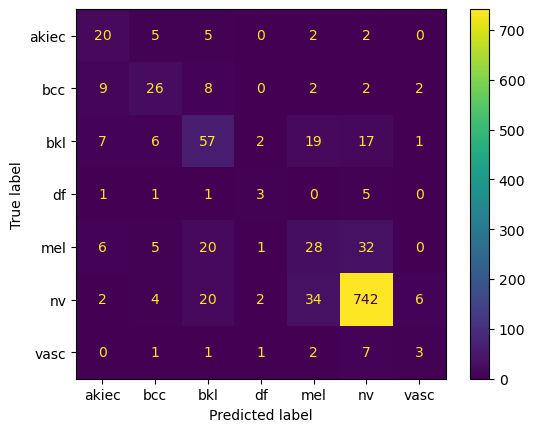

In [70]:
brf_bss = BalancedRandomForestClassifier(n_estimators=300, max_depth= 12, random_state=42, class_weight = 'balanced_subsample')

brf_bss.fit(X_train_res, y_train_res)
y_pred = brf_bss.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred), display_labels=brf_bss.classes_)
disp.plot()

Accuracy: 0.7582515611061552

Classification Report:
               precision    recall  f1-score   support

       akiec       0.30      0.40      0.35        35
         bcc       0.42      0.57      0.49        49
         bkl       0.44      0.41      0.43       109
          df       0.25      0.36      0.30        11
         mel       0.37      0.33      0.34        92
          nv       0.90      0.89      0.90       811
        vasc       0.64      0.50      0.56        14

    accuracy                           0.76      1121
   macro avg       0.48      0.49      0.48      1121
weighted avg       0.77      0.76      0.76      1121



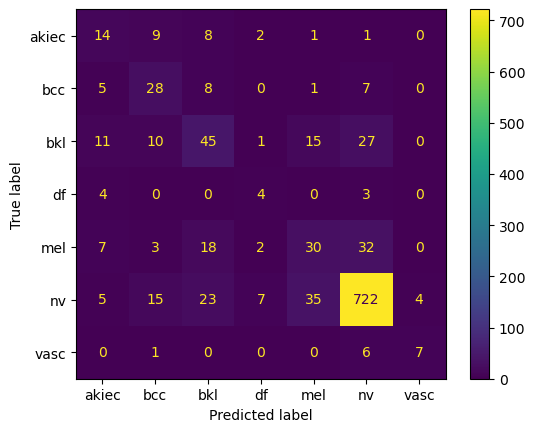

In [71]:
y_pred = brf_bss.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=brf_bss.classes_)
disp.plot()

In [72]:
y_pred = brf_bss.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print("\nClassification Report:\n", classification_report(y_train, y_pred))

Accuracy: 0.9734174794415759

Classification Report:
               precision    recall  f1-score   support

       akiec       0.85      1.00      0.92       159
         bcc       0.93      1.00      0.96       229
         bkl       0.96      0.97      0.96       509
          df       0.89      1.00      0.94        51
         mel       0.88      0.95      0.91       430
          nv       1.00      0.97      0.99      3782
        vasc       0.95      1.00      0.97        69

    accuracy                           0.97      5229
   macro avg       0.92      0.98      0.95      5229
weighted avg       0.98      0.97      0.97      5229



## Decision Tree

In [77]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state= 42)
param_grid = {
    'max_depth': [3,5,10,12]
}
grid_search = GridSearchCV(dt, param_grid, scoring = 'roc_auc_ovr')
grid_search.fit(X_train_res, y_train_res)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 12}
0.9394224465416985


Accuracy: 0.6598214285714286

Classification Report:
               precision    recall  f1-score   support

       akiec       0.27      0.50      0.35        34
         bcc       0.36      0.43      0.39        49
         bkl       0.32      0.44      0.37       109
          df       0.17      0.27      0.21        11
         mel       0.19      0.25      0.22        92
          nv       0.90      0.77      0.83       810
        vasc       0.14      0.20      0.16        15

    accuracy                           0.66      1120
   macro avg       0.34      0.41      0.36      1120
weighted avg       0.73      0.66      0.69      1120



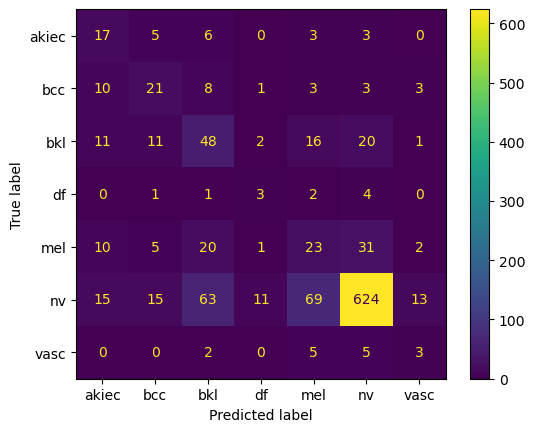

In [78]:
dt = DecisionTreeClassifier(class_weight='balanced', max_depth= 12)
dt.fit(X_train_res, y_train_res)

y_pred = dt.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred), display_labels=dt.classes_)
disp.plot()

## SVM

Accuracy: 0.7008928571428571

Classification Report:
               precision    recall  f1-score   support

       akiec       0.32      0.47      0.38        34
         bcc       0.37      0.49      0.42        49
         bkl       0.35      0.46      0.40       109
          df       0.20      0.18      0.19        11
         mel       0.28      0.39      0.33        92
          nv       0.92      0.81      0.86       810
        vasc       0.12      0.13      0.12        15

    accuracy                           0.70      1120
   macro avg       0.37      0.42      0.39      1120
weighted avg       0.76      0.70      0.72      1120



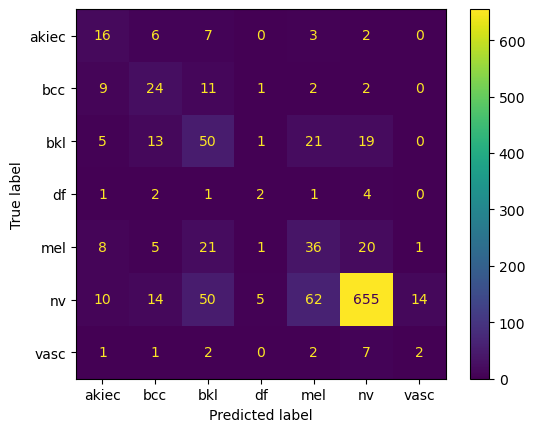

In [74]:
svc_model = SVC(class_weight='balanced')
svc_model.fit(X_train_res, y_train_res)

y_pred = svc_model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred), display_labels=svc_model.classes_)
disp.plot()